# MNIST 심화 과제

* Dataset 및 activation 함수 변경
* CIFA10의 입력 shape 확인
* SGD 와 adam 성능 비교
* Leaky ReLU와 Sigmoid 성능 비교
* Dropout을 적용한 이후의 generalization error 확인

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

다음은 dataset을 준비합니다.
train param을 통해 trainset과 testset을 분리해서 다운받습니다.

In [2]:
transform = transforms.ToTensor()

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

100%|██████████| 170M/170M [00:13<00:00, 12.8MB/s]


CIFAR10 : 10개 클래스로 분류되는 이미지 분류 데이터셋

아래 어떤 CLASS SET이 있는지 프린트 해본다

In [3]:
print(trainset.classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


trainset과 testset의 데이터 요약을 로그로 프린트 해보기

이건 컬러 데이터이기 때문에 cmap 과 데이터들이 바뀌어야 한다.

그리고 torch는 CHW 인데 plt는 HWC 로 print 해주기 때문에 이것도 변경해줘야함 (permute 사용)

C : Channel
H : Height
W : Width


In [4]:
def log_dataset(dataset):
    img_tensor = dataset[0][0]
    img_np = img_tensor.permute(1,2,0).numpy()

    class_name = dataset.classes[dataset[0][1]]
    print(f"[INFO] dataset len : {len(dataset)}")
    print(f"[INFO] dataset shape : {dataset[0][0].shape}")
    print(f"[INFO] dataset 1st data : {dataset[0][1]}")
    plt.imshow(img_np)
    plt.axis('off')
    plt.title(f"Label: {class_name}")
    plt.show()

[INFO] dataset len : 50000
[INFO] dataset shape : torch.Size([3, 32, 32])
[INFO] dataset 1st data : 6


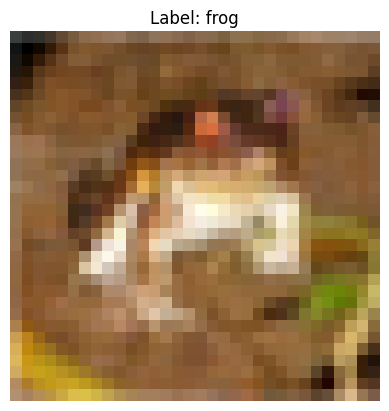

In [5]:
log_dataset(trainset)

[INFO] dataset len : 10000
[INFO] dataset shape : torch.Size([3, 32, 32])
[INFO] dataset 1st data : 3


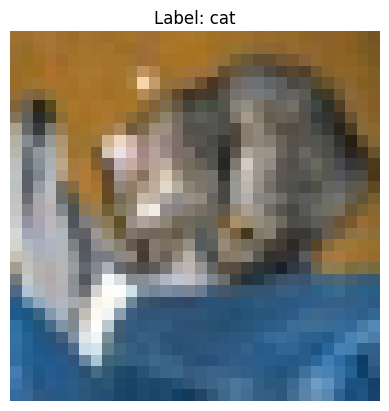

In [6]:
log_dataset(testset)

batch_size를 조건에 맞게 256으로 변경하고 dataloader를 설정한다
+) adam optimizer도 batch 사용

In [7]:
batch_size = 256

trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True
)

testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=batch_size,
    shuffle=False
)

이전 과제에서 사용했던 accuracy method도 선언해줍니다.

In [8]:
def accuracy(model, dataloader):
  cnt = 0
  acc = 0

  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    preds = torch.argmax(preds, dim=-1)

    cnt += labels.shape[0]
    acc += (labels == preds).sum().item()

  return acc / cnt

## plot 1

이번 과제에서도 출력 차원을 10으로 만들어야 합니다. 그리고 activation 함수를 LeakyReLU로 변환합니다.

데이터에 따른 입력 형태 변경 필요 : 32 * 32 * 3

++ 추가적으로 멘토링 시간에 마지막 layer에는 activation을 사용하지 않는 것이 맞다고 이야기 들어 제거하였습니다.

In [24]:
from torch import nn


class Model(nn.Module):
  def __init__(self, input_dim, n_dim):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)
    self.layer2 = nn.Linear(n_dim, n_dim)
    self.layer3 = nn.Linear(n_dim, 10)

    self.act = nn.LeakyReLU()

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.act(self.layer1(x))
    x = self.act(self.layer2(x))
    x = self.layer3(x)

    return x

SGD optimizer 선언

In [25]:
from torch.optim import SGD

lr = 0.001
SGD_model = Model(32*32*3, 1024).to('cuda')

SGD_optimizer = SGD(SGD_model.parameters(), lr=lr)

Adam optimizer 선언

In [26]:
from torch.optim import Adam

lr = 0.001
Adam_model = Model(32*32*3, 1024).to('cuda')

Adam_optimizer = Adam(Adam_model.parameters(), lr=lr)

model과 optimizer를 parameter로 받는 method 선언

In [27]:
def train_model(model, optimizer):
    n_epochs = 50
    loss_function = nn.CrossEntropyLoss()

    train_accuracy = []

    for epoch in range(n_epochs):
        total_loss = 0.
        for data in trainloader:
            model.zero_grad()
            inputs, labels = data
            inputs, labels = inputs.to('cuda'), labels.to('cuda')

            preds = model(inputs)
            loss = loss_function(preds, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        train_accuracy.append(accuracy(model, trainloader))
        print(f"Epoch {epoch:3d} | Loss: {total_loss}")
    return train_accuracy

SGD 버전과 Adam 버전을 학습합니다.

In [28]:
SGD_accuracy = train_model(SGD_model, SGD_optimizer)

Epoch   0 | Loss: 450.7595257759094
Epoch   1 | Loss: 448.3840732574463
Epoch   2 | Loss: 446.40382194519043
Epoch   3 | Loss: 444.4910321235657
Epoch   4 | Loss: 442.56044125556946
Epoch   5 | Loss: 440.48264598846436
Epoch   6 | Loss: 438.23551630973816
Epoch   7 | Loss: 435.76040840148926
Epoch   8 | Loss: 433.1221613883972
Epoch   9 | Loss: 430.2839410305023
Epoch  10 | Loss: 427.3235273361206
Epoch  11 | Loss: 424.2149803638458
Epoch  12 | Loss: 421.14288449287415
Epoch  13 | Loss: 418.0825960636139
Epoch  14 | Loss: 415.1182677745819
Epoch  15 | Loss: 412.30435943603516
Epoch  16 | Loss: 409.5898778438568
Epoch  17 | Loss: 407.21322774887085
Epoch  18 | Loss: 404.9154566526413
Epoch  19 | Loss: 402.7980133295059
Epoch  20 | Loss: 400.81190025806427
Epoch  21 | Loss: 398.9271869659424
Epoch  22 | Loss: 397.06868863105774
Epoch  23 | Loss: 395.3602213859558
Epoch  24 | Loss: 393.6660861968994
Epoch  25 | Loss: 392.13800609111786
Epoch  26 | Loss: 390.5999268293381
Epoch  27 | Loss:

In [29]:
Adam_accuracy = train_model(Adam_model, Adam_optimizer)

Epoch   0 | Loss: 366.4209246635437
Epoch   1 | Loss: 325.3439185619354
Epoch   2 | Loss: 306.1791253089905
Epoch   3 | Loss: 294.7156488895416
Epoch   4 | Loss: 285.9286130666733
Epoch   5 | Loss: 277.25083696842194
Epoch   6 | Loss: 271.36816251277924
Epoch   7 | Loss: 264.41149640083313
Epoch   8 | Loss: 258.0493412017822
Epoch   9 | Loss: 250.52855682373047
Epoch  10 | Loss: 245.24117147922516
Epoch  11 | Loss: 239.4138958454132
Epoch  12 | Loss: 235.6325408220291
Epoch  13 | Loss: 230.82438695430756
Epoch  14 | Loss: 224.092500269413
Epoch  15 | Loss: 219.82100427150726
Epoch  16 | Loss: 214.29970532655716
Epoch  17 | Loss: 208.06213754415512
Epoch  18 | Loss: 203.94094556570053
Epoch  19 | Loss: 199.27310782670975
Epoch  20 | Loss: 192.6458876132965
Epoch  21 | Loss: 187.170627951622
Epoch  22 | Loss: 185.00566136837006
Epoch  23 | Loss: 177.6281172633171
Epoch  24 | Loss: 172.129292011261
Epoch  25 | Loss: 165.861674785614
Epoch  26 | Loss: 162.26915848255157
Epoch  27 | Loss: 1

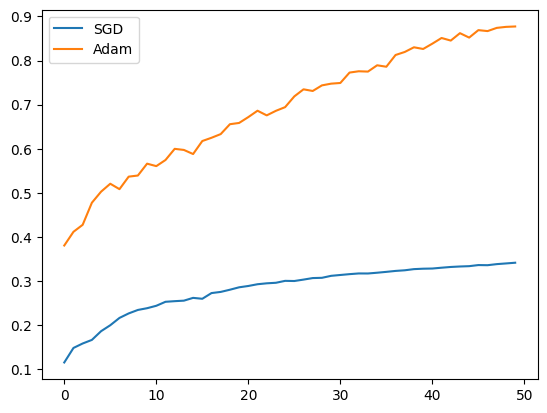

In [36]:
import numpy as np

def plot_acc(accs1, accs2, label1, label2):
  x = np.arange(len(accs1))

  plt.plot(x, accs1, label=label1)
  plt.plot(x, accs2, label=label2)
  plt.legend()
  plt.show()

plot_acc(SGD_accuracy, Adam_accuracy, "SGD", "Adam")

## plot 2
Leaky ReLU 와 Sigmoid 성능 비교
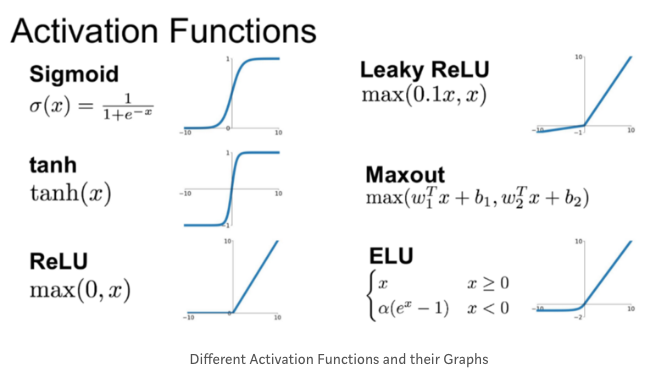

activation 함수를 init parameter로 받는 모델 class 생성

In [32]:
class act_custom_Model(nn.Module):
  def __init__(self, act, input_dim, n_dim):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)
    self.layer2 = nn.Linear(n_dim, n_dim)
    self.layer3 = nn.Linear(n_dim, 10)

    self.act = act

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.act(self.layer1(x))
    x = self.act(self.layer2(x))
    x = self.layer3(x)

    return x

LeakyReLU 를 activation 함수로 train

In [33]:
LeakyReLU_model = act_custom_Model(nn.LeakyReLU(), 32*32*3, 1024).to('cuda')
LeakyReLU_optimizer = Adam(LeakyReLU_model.parameters(), lr=lr)

LeakyReLU_accuracy = train_model(LeakyReLU_model, LeakyReLU_optimizer)

Epoch   0 | Loss: 367.7494993209839
Epoch   1 | Loss: 324.4163975715637
Epoch   2 | Loss: 306.3433142900467
Epoch   3 | Loss: 293.4969285726547
Epoch   4 | Loss: 285.8135678768158
Epoch   5 | Loss: 277.3883341550827
Epoch   6 | Loss: 268.84459400177
Epoch   7 | Loss: 263.92203438282013
Epoch   8 | Loss: 258.45223331451416
Epoch   9 | Loss: 251.65727412700653
Epoch  10 | Loss: 245.69866955280304
Epoch  11 | Loss: 241.71843087673187
Epoch  12 | Loss: 233.79652452468872
Epoch  13 | Loss: 229.7338845729828
Epoch  14 | Loss: 224.94217574596405
Epoch  15 | Loss: 218.92464864253998
Epoch  16 | Loss: 213.82614451646805
Epoch  17 | Loss: 208.77455228567123
Epoch  18 | Loss: 202.75685107707977
Epoch  19 | Loss: 198.98054313659668
Epoch  20 | Loss: 192.4267699122429
Epoch  21 | Loss: 186.76592415571213
Epoch  22 | Loss: 183.26962280273438
Epoch  23 | Loss: 176.7795773744583
Epoch  24 | Loss: 171.99166518449783
Epoch  25 | Loss: 168.42077565193176
Epoch  26 | Loss: 159.80480301380157
Epoch  27 | L

Sigmoid 를 activation 함수로 train

In [34]:
Sigmoid_model = act_custom_Model(nn.Sigmoid(), 32*32*3, 1024).to('cuda')
Sigmoid_optimizer = Adam(Sigmoid_model.parameters(), lr=lr)

Sigmoid_accuracy = train_model(Sigmoid_model, Sigmoid_optimizer)

Epoch   0 | Loss: 390.36738872528076
Epoch   1 | Loss: 343.1275256872177
Epoch   2 | Loss: 325.0171525478363
Epoch   3 | Loss: 312.6256377696991
Epoch   4 | Loss: 303.8213733434677
Epoch   5 | Loss: 296.1432636976242
Epoch   6 | Loss: 290.54017901420593
Epoch   7 | Loss: 283.88348627090454
Epoch   8 | Loss: 279.6558635234833
Epoch   9 | Loss: 274.8669710159302
Epoch  10 | Loss: 270.62883174419403
Epoch  11 | Loss: 265.7823385000229
Epoch  12 | Loss: 263.6078757047653
Epoch  13 | Loss: 258.6528205871582
Epoch  14 | Loss: 256.2396854162216
Epoch  15 | Loss: 252.44625747203827
Epoch  16 | Loss: 247.14289546012878
Epoch  17 | Loss: 245.4139003753662
Epoch  18 | Loss: 241.13852381706238
Epoch  19 | Loss: 239.43175518512726
Epoch  20 | Loss: 234.63997316360474
Epoch  21 | Loss: 232.08262020349503
Epoch  22 | Loss: 227.54330223798752
Epoch  23 | Loss: 227.8916014432907
Epoch  24 | Loss: 222.36738628149033
Epoch  25 | Loss: 220.73174101114273
Epoch  26 | Loss: 217.79909253120422
Epoch  27 | Lo

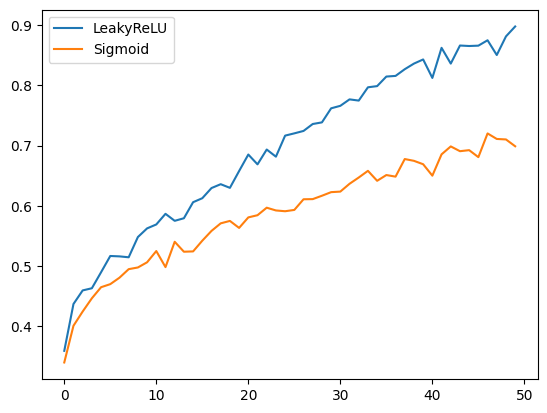

In [37]:
plot_acc(LeakyReLU_accuracy, Sigmoid_accuracy, "LeakyReLU", "Sigmoid")

## plot 3
Dropout을 적용한 이후의 generalization error 확인

In [38]:
class dropout_Model(nn.Module):
  def __init__(self, input_dim, n_dim):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)
    self.layer2 = nn.Linear(n_dim, n_dim)
    self.layer3 = nn.Linear(n_dim, 10)

    self.act = nn.LeakyReLU()
    self.dropout = nn.Dropout(p=0.1)

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.act(self.layer1(x))
    x = self.dropout(x)
    x = self.act(self.layer2(x))
    x = self.dropout(x)
    x = self.layer3(x)

    return x

In [39]:
dropout_model = dropout_Model(32*32*3, 1024).to('cuda')
dropout_optimizer = Adam(dropout_model.parameters(), lr=lr)

In [40]:
def train_dropout_model(model, optimizer):
    n_epochs = 50
    loss_function = nn.CrossEntropyLoss()

    train_accuracy = []
    test_accuracy = []

    for epoch in range(n_epochs):
        total_loss = 0.
        model.train() #dropout 등 작동하도록

        for data in trainloader:
            model.zero_grad()
            inputs, labels = data
            inputs, labels = inputs.to('cuda'), labels.to('cuda')

            preds = model(inputs)
            loss = loss_function(preds, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        with torch.no_grad():
            model.eval() #평가 중 dropout 비활성화

            train_acc = accuracy(model, trainloader)
            test_acc = accuracy(model, testloader)
        train_accuracy.append(train_acc)
        test_accuracy.append(test_acc)
        print(f"Epoch {epoch:3d} | Loss: {total_loss}")
    return train_accuracy, test_accuracy

In [41]:
dropout_train_acc, dropout_test_acc = train_dropout_model(dropout_model, dropout_optimizer)

Epoch   0 | Loss: 369.60213029384613
Epoch   1 | Loss: 333.2520227432251
Epoch   2 | Loss: 315.64964032173157
Epoch   3 | Loss: 305.7637873888016
Epoch   4 | Loss: 296.45177471637726
Epoch   5 | Loss: 290.4425698518753
Epoch   6 | Loss: 284.07400941848755
Epoch   7 | Loss: 280.01357650756836
Epoch   8 | Loss: 273.50697803497314
Epoch   9 | Loss: 268.88649547100067
Epoch  10 | Loss: 265.3730080127716
Epoch  11 | Loss: 261.77909791469574
Epoch  12 | Loss: 257.3734143972397
Epoch  13 | Loss: 253.93982243537903
Epoch  14 | Loss: 250.46617877483368
Epoch  15 | Loss: 247.26106917858124
Epoch  16 | Loss: 243.2421350479126
Epoch  17 | Loss: 239.10229408740997
Epoch  18 | Loss: 237.00417506694794
Epoch  19 | Loss: 233.1224389076233
Epoch  20 | Loss: 230.1858410835266
Epoch  21 | Loss: 227.9200211763382
Epoch  22 | Loss: 225.55746614933014
Epoch  23 | Loss: 221.11877781152725
Epoch  24 | Loss: 219.39600110054016
Epoch  25 | Loss: 214.31163090467453
Epoch  26 | Loss: 211.29414772987366
Epoch  27 

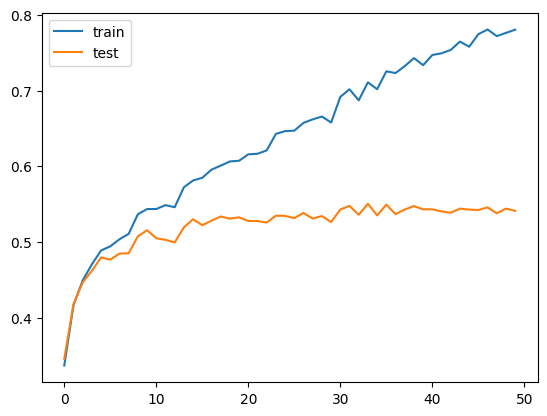

In [42]:
plot_acc(dropout_train_acc, dropout_test_acc, "train", "test")

## 추가 학습
dropout 적용 전보다 train_acc가 줄어들기는 했지만 test_acc 가 train_acc를 못따라가는 걸로 보인다.
일단 적용 전의 test_acc는 뽑아본적이 없기 때문에 dropout 적용 전에 test_acc를 뽑아보기로 한다.

In [44]:
def train_test_model(model, optimizer):
    n_epochs = 50
    loss_function = nn.CrossEntropyLoss()

    train_accuracy = []
    test_accuracy = []

    for epoch in range(n_epochs):
        total_loss = 0.

        for data in trainloader:
            model.zero_grad()
            inputs, labels = data
            inputs, labels = inputs.to('cuda'), labels.to('cuda')

            preds = model(inputs)
            loss = loss_function(preds, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()


        train_acc = accuracy(model, trainloader)
        test_acc = accuracy(model, testloader)
        train_accuracy.append(train_acc)
        test_accuracy.append(test_acc)
        print(f"Epoch {epoch:3d} | Loss: {total_loss}")
    return train_accuracy, test_accuracy

In [46]:
additional_test_model = act_custom_Model(nn.LeakyReLU(), 32*32*3, 1024).to('cuda')
additional_test_optimizer = Adam(additional_test_model.parameters(), lr=lr)

Leaky_train_acc, Leaky_test_acc = train_test_model(additional_test_model, additional_test_optimizer)

Epoch   0 | Loss: 366.2078869342804
Epoch   1 | Loss: 323.82709181308746
Epoch   2 | Loss: 305.79995834827423
Epoch   3 | Loss: 293.08791422843933
Epoch   4 | Loss: 284.0695136785507
Epoch   5 | Loss: 276.3332395553589
Epoch   6 | Loss: 269.14026486873627
Epoch   7 | Loss: 263.043727517128
Epoch   8 | Loss: 257.2885799407959
Epoch   9 | Loss: 251.11773920059204
Epoch  10 | Loss: 245.28786611557007
Epoch  11 | Loss: 240.1710193157196
Epoch  12 | Loss: 235.19129729270935
Epoch  13 | Loss: 229.37908971309662
Epoch  14 | Loss: 223.8735467195511
Epoch  15 | Loss: 217.86393004655838
Epoch  16 | Loss: 212.5871290564537
Epoch  17 | Loss: 208.10989302396774
Epoch  18 | Loss: 204.18151837587357
Epoch  19 | Loss: 199.02230823040009
Epoch  20 | Loss: 193.32336312532425
Epoch  21 | Loss: 187.3664689064026
Epoch  22 | Loss: 183.6892066001892
Epoch  23 | Loss: 176.76055824756622
Epoch  24 | Loss: 171.86305314302444
Epoch  25 | Loss: 165.03949028253555
Epoch  26 | Loss: 160.18527168035507
Epoch  27 | 

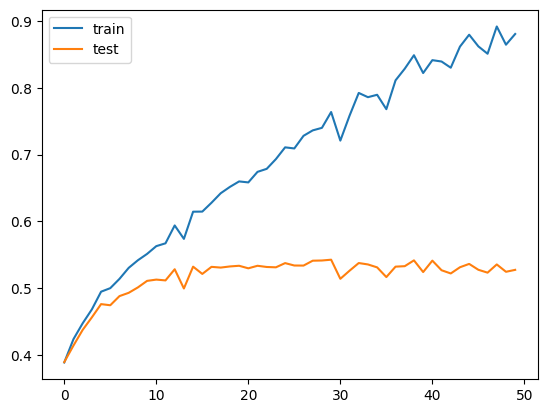

In [47]:
plot_acc(Leaky_train_acc, Leaky_test_acc, "train", "test")

In [52]:
print("### dropout 이전 50epoch 성능")
print(f"train acc : {Leaky_train_acc[49]}")
print(f"test  acc : {Leaky_test_acc[49]}")
print("### dropout 이후 50epoch 성능")
print(f"train acc : {dropout_train_acc[49]}")
print(f"test  acc : {dropout_test_acc[49]}")

### dropout 이전 50epoch 성능
train acc : 0.88054
test  acc : 0.5274
### dropout 이후 50epoch 성능
train acc : 0.78036
test  acc : 0.5412



| 모델 종류     | Train Accuracy | Test Accuracy |
|--------------|----------------|----------------|
| Dropout 이전 | 0.88054        | 0.5274         |
| Dropout 이후 | 0.78036        | 0.5412         |

dropout를 적용한 모델은 train accuracy는 줄어들었지만 test accuracy가 올라간 것으로 보아 overfitting 을 줄여 일반화 성능을 높였다고 볼 수 있다.
하지만 test accuracy가 마음에 들지는 않는다.

#### 예상되는 원인
* 모델에 비해 dropout을 2번이나 해서 너무 parameter 소실이 컸을 수 있을 것 같음
* lr이 너무 작음 -> 파라미터 문제들은 최적화 필요..
* 애초에 적합한 모델이 아님? -> 이건 현재 실험해볼 수 있는 건 없음

### test2
dropout을 한번만 해보기

In [55]:
class test2_Model(nn.Module):
  def __init__(self, input_dim, n_dim):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)
    self.layer2 = nn.Linear(n_dim, n_dim)
    self.layer3 = nn.Linear(n_dim, 10)

    self.act = nn.LeakyReLU()
    self.dropout = nn.Dropout(p=0.1)

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.act(self.layer1(x))
    x = self.act(self.layer2(x))
    x = self.dropout(x)
    x = self.layer3(x)

    return x

In [56]:
test2_model = test2_Model(32*32*3, 1024).to('cuda')
test2_optimizer = Adam(test2_model.parameters(), lr=lr)

In [57]:
test2_train_acc, test2_test_acc = train_dropout_model(test2_model, test2_optimizer)

Epoch   0 | Loss: 366.4919776916504
Epoch   1 | Loss: 324.4823830127716
Epoch   2 | Loss: 307.34059262275696
Epoch   3 | Loss: 295.0782405138016
Epoch   4 | Loss: 287.94739496707916
Epoch   5 | Loss: 278.7818533182144
Epoch   6 | Loss: 272.5287666320801
Epoch   7 | Loss: 265.6722946166992
Epoch   8 | Loss: 258.1205372810364
Epoch   9 | Loss: 253.3699094057083
Epoch  10 | Loss: 248.4777753353119
Epoch  11 | Loss: 244.3427196741104
Epoch  12 | Loss: 238.23538410663605
Epoch  13 | Loss: 235.61145722866058
Epoch  14 | Loss: 228.87339460849762
Epoch  15 | Loss: 222.31842350959778
Epoch  16 | Loss: 218.36199170351028
Epoch  17 | Loss: 215.28246039152145
Epoch  18 | Loss: 208.69503784179688
Epoch  19 | Loss: 202.97057342529297
Epoch  20 | Loss: 200.0351232290268
Epoch  21 | Loss: 195.95990562438965
Epoch  22 | Loss: 191.30420976877213
Epoch  23 | Loss: 186.86276865005493
Epoch  24 | Loss: 181.74363005161285
Epoch  25 | Loss: 178.831503033638
Epoch  26 | Loss: 173.80171781778336
Epoch  27 | Lo

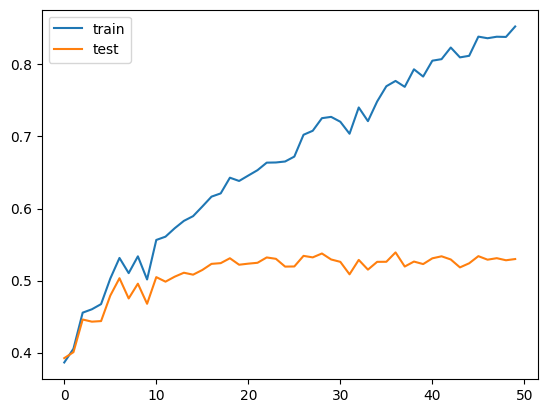

In [58]:
plot_acc(test2_train_acc, test2_test_acc, "train", "test")

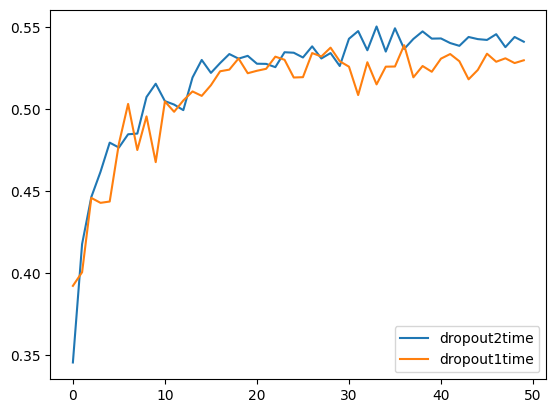

In [59]:
plot_acc(dropout_test_acc, test2_test_acc, "dropout2time", "dropout1time")

dropout 이슈는 아닌 것 같다 뭔가 모델이 적합하지 않을 수도 있어보인데 이미지를 flatten 하는 부분이 의심간다.
이미지를 한줄로 만들면서 복잡한 개체에 대한 부분이 의미가 없어지는 것으로 의심이 간다.